In [8]:
from sklearn.discriminant_analysis import StandardScaler
import torch
import pandas as pd

# Get Data

In [11]:
# Get Data
train_val = pd.read_pickle('./TrainValSets2.pkl')
X_all = train_val.drop(['is_goal'], axis=1)
y_all = train_val['is_goal']

# Split into train val
X_train, X_val, y_train, y_val = train_test_split(X_all, y_all, test_size=0.3, random_state=42)

# Create dataloaders for NN
# Feature Scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)

# Converting to PyTorch tensors
X_train_tensor = torch.tensor(X_train_scaled, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32)
X_val_tensor = torch.tensor(X_val_scaled, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val.values, dtype=torch.float32)

___

# Neural Network

In [13]:
from ift6758.training import Net

nn_configs = {
    'small_nn_1': [32, 16],
    'small_nn_2': [64],
    'small_nn_3': [64, 64],
    'small_nn_4': [256, 128],
    'deeper_nn_1': [256, 128, 64, 64, 32],
    'deeper_nn_2': [512, 256, 128, 64, 32, 16],
    }

In [24]:
import os

models_dict = {}
model_files_dir = '../../train/custom_nn_models/'

for model_name, hidden_layers in nn_configs.items():
    model = Net(X_train.shape[1], hidden_layers, 1)
    model.load_state_dict(torch.load(os.path.join(model_files_dir, model_name, 'model.pt')))

    outputs = model(X_val_tensor.to(model.device))
    prob = outputs.cpu().detach().numpy()[:, 0]
    
    models_dict[model_name] = prob

### Plots

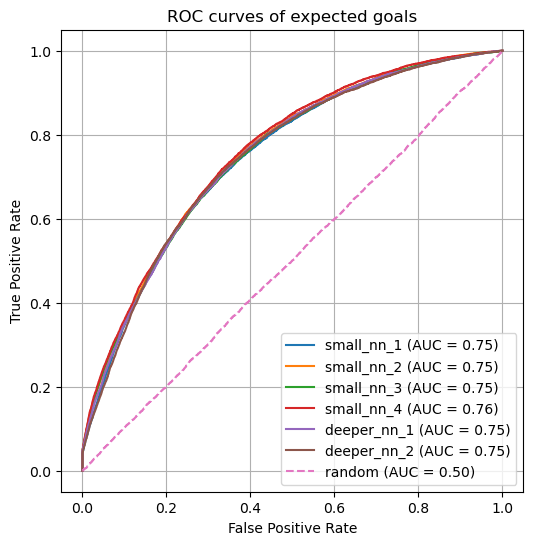

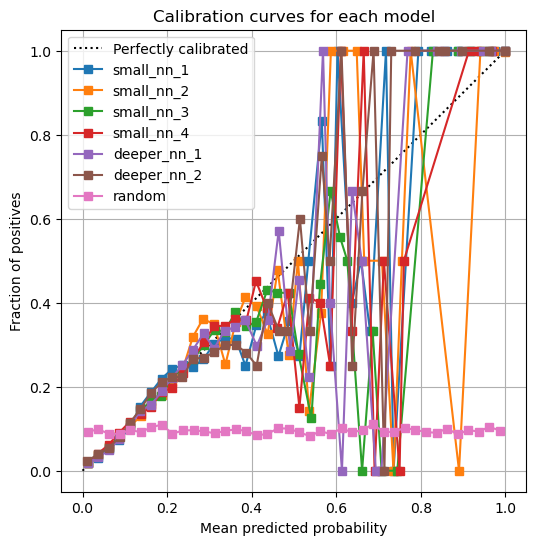

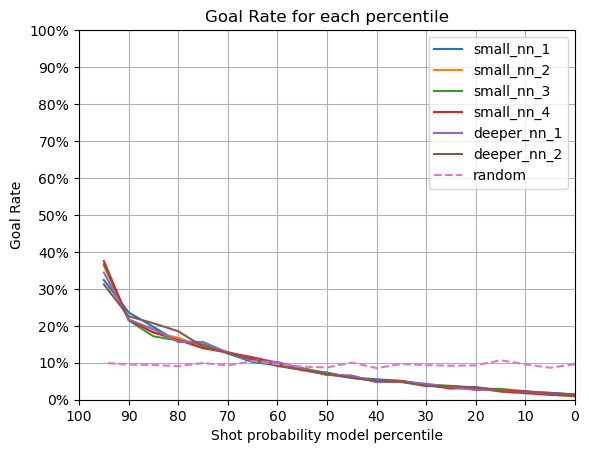

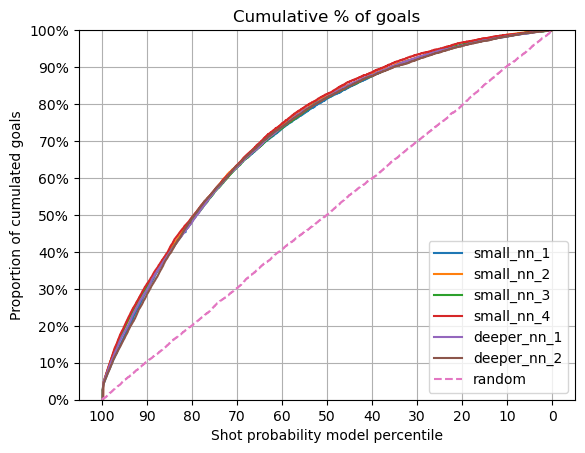

In [25]:
from ift6758.training.plot import plot_all

plot_all(models_dict, y_val)

------

# Random Forest

In [20]:
X = df.drop('is_goal', axis=1)
y = df['is_goal']

In [21]:
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from ift6758.training import BasicModel
from sklearn.metrics import classification_report

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)

model = BasicModel(rf_classifier)
model.train(X_train, y_train)

y_pred, accuracy = model.evaluate(X_test, y_test)
print(f"Accuracy: {accuracy:.4f}")

probabilities = model.get_pred_proba(X_test)

# model.save("random_forest_model.pkl")

print(classification_report(y_test, y_pred))

Accuracy: 0.9080
              precision    recall  f1-score   support

           0       0.91      1.00      0.95     63060
           1       0.72      0.07      0.12      6699

    accuracy                           0.91     69759
   macro avg       0.82      0.53      0.54     69759
weighted avg       0.89      0.91      0.87     69759



In [22]:
importances = rf_classifier.feature_importances_

feature_names = X_train.columns
feature_importances = pd.DataFrame(importances, index=feature_names, columns=["importance"]).sort_values("importance", ascending=False)

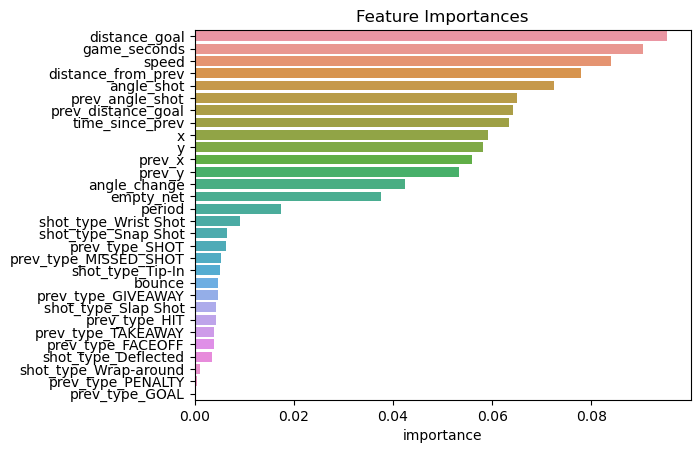

In [23]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.barplot(x="importance", y=feature_importances.index, data=feature_importances)
plt.title("Feature Importances")
plt.show()

In [ ]:
from eli5.sklearn import PermutationImportance
import eli5
perm = PermutationImportance(rf_classifier, random_state=42).fit(X_test, y_test)

eli5.show_weights(perm, feature_names = X_test.columns.tolist())

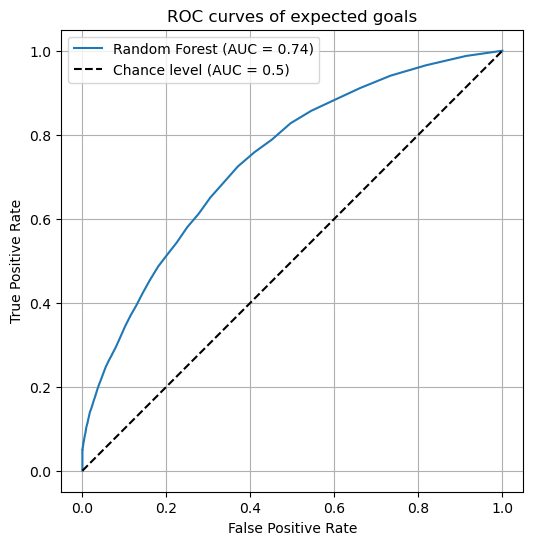

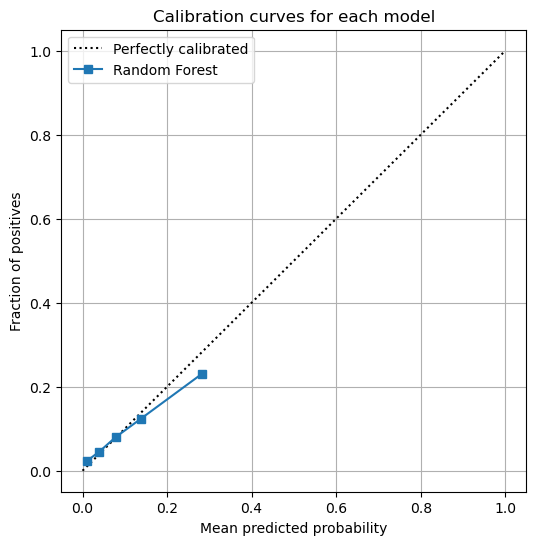

ValueError: x and y must have same first dimension, but have shapes (20,) and (17,)

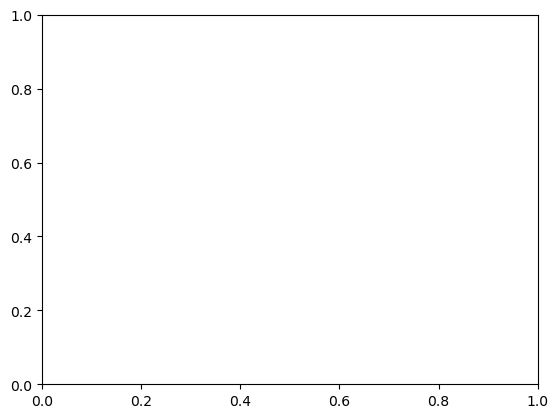

In [24]:
models_dict = {
    'Random Forest': probabilities
}

from ift6758.training.plot import plot_all

plot_all(models_dict, y_test, save_to_folder="./plots")

# Data sets division

In [25]:
from ift6758.data.cleaning import DataCleaner

data_path_clean = './../../ift6758/data/json_clean/'
data_cleaner = DataCleaner(data_raw=nhl_games_data, data_path_clean=data_path_clean)
for year in range(2016,2021):
    data_cleaner.clean_season(year, keepPreviousEventInfo=True, includePowerPlay=False)

In [26]:
dict = data_cleaner.get_team_games_seasons(2016, 2021)

In [27]:
from ift6758.features import FeatureEng
data_path_clean = './../../ift6758/data/json_clean/'
w = FeatureEng(data_path_clean)

In [28]:
df = w.features_2(2016,2021, drop_teams=False)
df.shape

(348794, 21)

### Removing first games for each team

In [29]:
w.remove_first_team_games(df, dict, 20, 10)
df.shape

(329926, 21)

In [30]:
categorical_features = ['shot_type', 'prev_type']
df = w.encodeCategories(df, categorical_features)

### Splitting train and validation data by season

In [31]:
df['season'] = df['game_id'].astype(str).str[:4].astype(int)

train_seasons = [2016, 2017, 2018, 2019]
val_seasons = [2020]

train_df = df[df['season'].isin(train_seasons)]
val_df = df[df['season'].isin(val_seasons)]

train_df = train_df.drop(columns=['game_id', 'season', 'team'])
val_df = val_df.drop(columns=['game_id', 'season', 'team'])

In [32]:
X_train = train_df.drop('is_goal', axis=1) 
y_train = train_df['is_goal']

X_test = val_df.drop('is_goal', axis=1)
y_test = val_df['is_goal']

In [33]:
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)

model = BasicModel(rf_classifier)
model.train(X_train, y_train)

y_pred, accuracy = model.evaluate(X_test, y_test)
print(f"Accuracy: {accuracy:.4f}")

probabilities = model.get_pred_proba(X_test)

# model.save("random_forest_model.pkl")

print(classification_report(y_test, y_pred))


Accuracy: 0.9056
              precision    recall  f1-score   support

           0       0.91      1.00      0.95     45705
           1       0.74      0.07      0.13      5010

    accuracy                           0.91     50715
   macro avg       0.82      0.53      0.54     50715
weighted avg       0.89      0.91      0.87     50715



We can try normalizing the data next with MinMaxScaler(feature_range=(0, 1))